# How to calculate the disconnected (= Gaussian) power spectrum covariance for cutsky geometry

Reference: [Yin Li+18](https://arxiv.org/abs/1811.05714).

## Given an input theory $P(k)$

In [1]:
import sys
sys.path.insert(0, '/global/u2/a/adematti/cosmodesi/jax-power')

from functools import partial

from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import random, jit

from cosmoprimo.fiducial import DESI

from jaxpower import MeshAttrs, Mesh2SpectrumPole, Mesh2SpectrumPoles, BinMesh2SpectrumPoles, compute_spectrum2_covariance, compute_fkp2_covariance_window


def get_theory_poles(k):
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    pk = pk1d(k)
    poles = {0: (1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk,
             2: 0.99 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,  # 0.99 scaling to be able to use local line-of-sight in the mock generation
             4: 8. / 35 * beta ** 2 * pk}
    return poles

## Define survey geometry

In [2]:
mattrs = MeshAttrs(boxsize=3000., boxcenter=[0., 0., 2200], meshsize=128)

def generate_survey_sample(size, seed, paint=False):
    # Generate a collection of particles with the survey geometry
    from jaxpower import ParticleField
    # Generate Gaussian-distributed positions
    positions = random.normal(seed, shape=(size, 3))
    mask = jnp.all((positions > -1.) & (positions < 1.), axis=-1)
    positions = positions * 0.25 * mattrs.boxsize + mattrs.boxcenter
    toret = ParticleField(positions, weights=1. * mask, attrs=mattrs)
    if paint: toret = toret.paint(resampler='cic', interlacing=0, compensate=False)
    return toret


## Compute window (must be done only once)

In [3]:
# To compute the window functions for the covariance matrix,
# better use randoms that represent the noise in the data (similar scatter of weights, if any)
# Of course, you can use more randoms, and provide alpha = (number of data) / (number of randoms)
size = int(2e6)  # number of data points
# More randoms than data
alpha = 0.05
randoms = generate_survey_sample(int(size / alpha), random.key(42), paint=False)

windows = compute_fkp2_covariance_window(randoms, alpha=alpha, edges={'step': mattrs.cellsize.min()},
                                         interlacing=2, resampler='tsc', los='local')

## Compute cutsky covariance

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


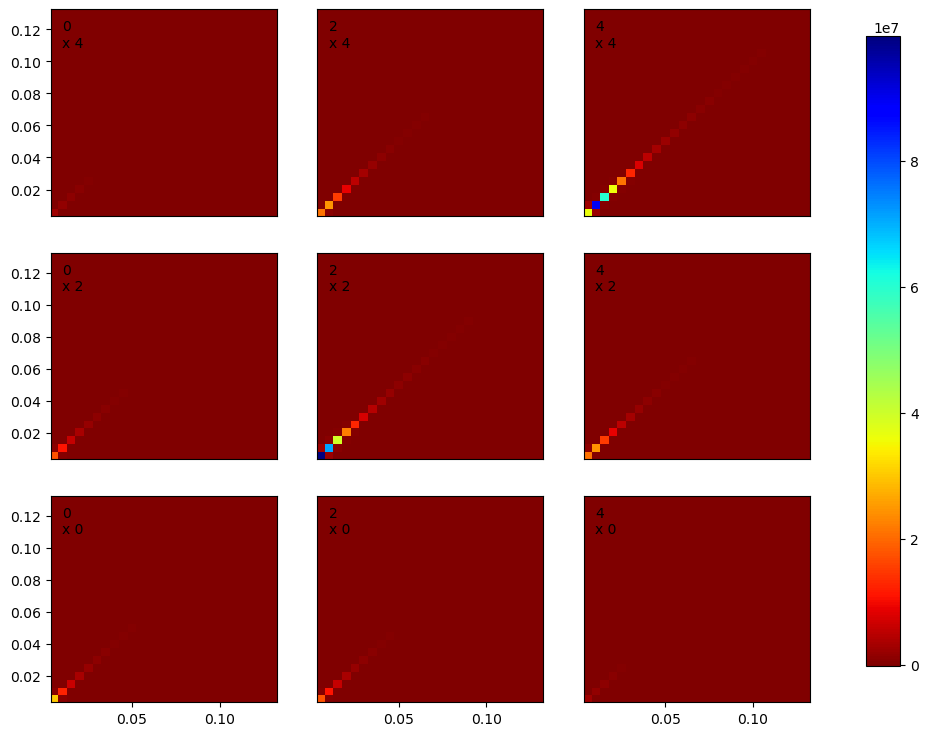

In [4]:
# Then compute the covariance matrix
# First get the theory. We compute the theory with finer binning than the observed power spectrum.
# Then we will rebin the covariance matrix.
# We use BinMesh2SpectrumPoles to obtain the number of modes in each bin.
bin = BinMesh2SpectrumPoles(mattrs, edges={'step': 0.005}, ells=(0, 2, 4))
theory = []
for ell, value in get_theory_poles(bin.xavg).items():
    theory.append(Mesh2SpectrumPole(k=bin.xavg, k_edges=bin.edges, nmodes=bin.nmodes, num_raw=value, ell=ell))
theory = Mesh2SpectrumPoles(theory)

# delta is the maximum abs(kj - ki) where the covariance will be computed (to speed up calculation)
covs_analytical = compute_spectrum2_covariance(windows, theory, delta=0.2)

# Sum all contributions (WW, WS, SS), with W = standard window (multiplying delta), S = shotnoise
WW, WS, SS = (cov.value() for cov in covs_analytical)
ratio = (1 + alpha)  # here alpha is (number of data) / (number of randoms) used in the power spectrum measurements
cov_analytical = covs_analytical[0].clone(value=WW + ratio * WS + ratio**2 * SS)
cov_analytical.plot(show=True);